In [5]:
using DifferentialEquations, Plots, StatsBase

For this example we'll use a different autonomous dynamical system - this is just to generate data and generate data from a system for which we've got a pretty good idea what the correlation dimension should be anyway. The so-called Halvorsen system is an example of a $circulant$ system - that is, one in which each of the expression on the RHS is the same, just permuted. This is the same system that we used when computing False Nearest Neighbours

In [6]:
function halvorsen!(du,u,p,t)
    a = p
    x,y,z = u
    
    f(x,y,z) = -a*x-4*y-4*z-y^2
    du[1] = f(x,y,z)
    du[2] = f(y,z,x)
    du[3] = f(z,x,y)
end

halvorsen! (generic function with 1 method)

In [7]:
u0 = [-6.4,0,0]
tspan = (0.0, 500.0)
param=1.3
prob = ODEProblem(halvorsen!,u0,tspan,param)
sol=solve(prob,dt=0.05)
plot(sol,xlims=(450,500))

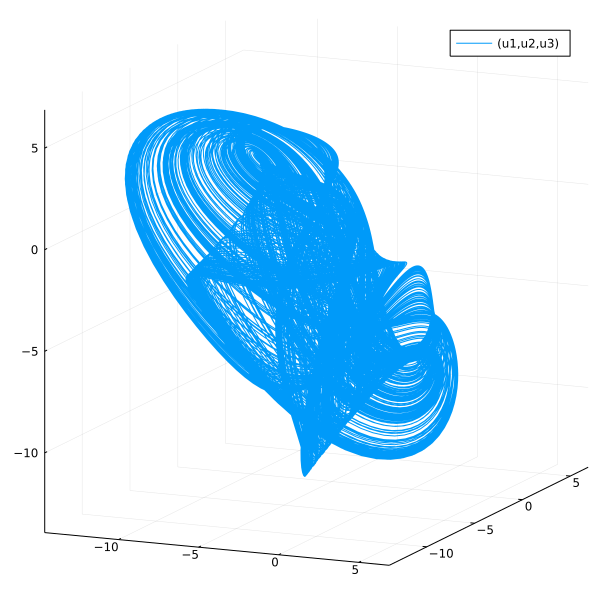

In [8]:
plot(sol,vars=(1,2,3),size=(600,600))

In [9]:
z=sol[1,:]

4797-element Vector{Float64}:
 -6.4
 -6.071943945303317
 -6.004531972565829
 -6.4546269735739195
 -7.549616324616156
 -8.634722178723806
 -7.636652734730634
 -3.9691431642329666
 -1.0456736265609665
 -0.14566826937352317
 -0.45434351004558104
 -0.8833941534336509
 -1.4009270134376701
  ⋮
 -5.571501946772198
 -6.472627510622358
 -6.2132022554467055
 -5.4838400910666225
 -5.281419618598459
 -6.597303092783548
 -9.290653937627143
 -8.369775051386837
 -3.6832429123499355
 -2.0449549040439567
 -3.255671492833374
 -3.6294405613751297

``z`` is just the data vector, this is all we care about from here.

## Compute a suitable embedding

Correlation dimension algorithms work on clouds of points, the first thing we need is to transform the vector ``z`` into a *cloud* of points which we can analyse - this is represented as a matrix ``X`` and we arrive at it as we did before.

First estimate and embedding lag

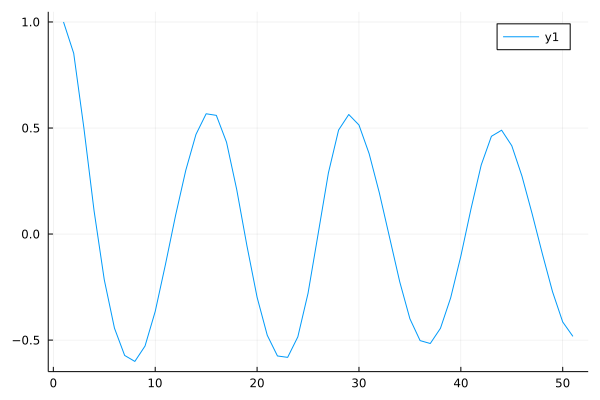

In [10]:
plot(autocor(z,0:50))   #OK, for the purposed ot the aiggnment, I guess this could be implemented from scratch!

And, then an embedding dimension.

In [11]:
function embed(z,m::Int64=3,τ::Int64=1)
    N=length(z)
    TN=N-(m-1)*τ
    ind=1:TN
    X=reshape(z[ind],1,TN)
    t0=1
    while t0<m
        X = [X; reshape(z[ind .+ t0*τ],1,TN)]
        t0 += 1
    end
    return X
end

embed (generic function with 3 methods)

In [12]:
function fnn(z,mmax::Int64=10,τ::Int64=1,Rth=15, Tth=0)
    #Compute the fraction of false nearest neighbours in embedding of dimension 1:mmax of z
    # τ is the embedding lag
    #Rth the threshold of neighbourly-ness
    #Tth the Theiler exclusion window (0 meaning none)
    fcount = Array{Float64, 1}(undef, mmax)
    nz=length(z)
    dt=[]
    s=[]
    # my version of rms:
    function myrms(x)
        return sqrt.(sum(x.^2,dims=1))
    end
    # loop of the embedding dimensions
    for m in 1:mmax
        # embed the data in dimension m
        vt=embed(z[1:nz-τ],m,τ)
        s=Array{Int32, 1}(undef, nz-m*τ)
        dnn=Array{Float64, 1}(undef, nz-m*τ)
        #naive implementation of find the nearest neighbours of each point - could be sloooow...
        for i in 1:(nz-m*τ) 
            ddist=myrms(vt-vt[:,i]*ones(1,nz-m*τ)) #distance from vt[:,i] to every point in vt
            si=argmin(ddist,dims=2)                #shortest distance
            while abs(si[1][2]-i)<=Tth             #ensure that the shortest distance is ...
                ddist[si[1]]=Inf                   #outside the Theiler exclusion window 
                si=argmin(ddist,dims=2)            #it's a clumsy notation, by si[1] is the coordinate 
            end                                    #and si[1][2] is the index
            s[i]=si[1][2]                          #s[i] is the index of the nearest neighbour of vt[:,i] 
            dnn[i]=ddist[si[1]]                    #and dnn[i] is that distance
        end
        #now compute D(t)=|x[s+mτ]-x[t+mτ]/dnn
        dt=abs.(z[s .+ m*τ] - z[(m*τ+1):end])./dnn
        fcount[m]=sum(x->x>Rth, dt)/length(dt)
    end
    return fcount
end

fnn (generic function with 5 methods)

In [13]:
fn = fnn(z,10,3,5)

10-element Vector{Float64}:
 0.9924906132665833
 0.4533500313087038
 0.08521303258145363
 0.023824451410658306
 0.005855290673358427
 0.002301736765013601
 0.0004187604690117253
 0.00020951183741881415
 0.0
 0.0

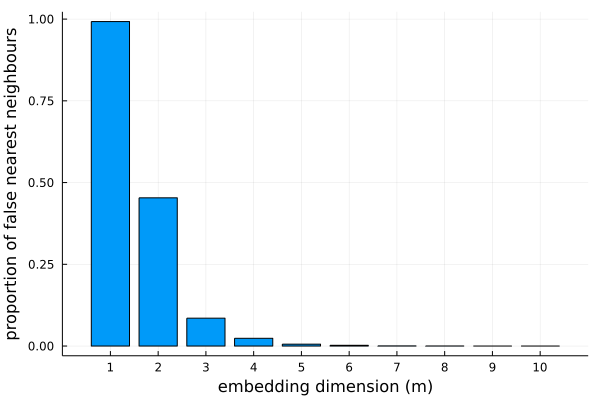

In [14]:
plot(fn,seriestype=:bar,xtick=1:10,xlabel="embedding dimension (m)",ylabel="proportion of false nearest neighbours",legend=false)

So here we are, ``X`` is a cloud of data points - one point per column.

In [15]:
X=embed(z,4,3)

4×4788 Matrix{Float64}:
 -6.4       -6.07194   -6.00453   -6.45463   …  -5.5715   -6.47263  -6.2132
 -6.45463   -7.54962   -8.63472   -7.63665      -5.48384  -5.28142  -6.5973
 -7.63665   -3.96914   -1.04567   -0.145668     -9.29065  -8.36978  -3.68324
 -0.145668  -0.454344  -0.883394  -1.40093      -2.04495  -3.25567  -3.62944

We need to get the CDF of interpoint distances, to do this we need to estimate the distance between every pair of points in the data set. First, ``dist_Xv(X,v)`` calculates the distance from a single point ``v`` (a column vector/array) and each column of ``X``. These columns must be the same length. This function will also (recurvsively) deal with several different reference vectors  ``v`` --- if ``v`` is an ``dv\times nv`` array, this would mean ``nv`` distinct vectors.

In [16]:
function dist_Xv(X,v) 
    #compute the distance between a vector v and columnwise elements of X
    #if v has multiple columns, do it for each and concatenate
    dx,nx=size(X)
    dv=size(v,1)
    nv=size(v,2)
    function dist_rms(X) #built in distance function, ensures that the edge cases are 
        dx,nx=size(X)
        if dx==1
            return abs(X)
        else
            return sqrt.(sum(X.^2,dims=1))
        end
    end
    if dx!=dv
        print("dimensions don't agree")
    end
    if nv>1
        d=Array{Float64,2}(undef,nv,nx)
        for i in 1:nv
            d[i,:]=dist_Xv(X,v[:,i])
        end
    else
        dX=X-v*ones(1,nx)
        d=dist_rms(dX)
    end
    return d
end


dist_Xv (generic function with 1 method)

And use this to compute the distances between all unique (and distinct) pairs. Note, if we were lazy we could just do ``dist_Xv(X,X)`` but this would include ``0``'s on the main diagonal and count every distances exactly twice.

In [17]:
function dist_all(X)
    #compute all interpoint distances of columns of X
    dx,nx=size(X)
    dd=Array{Float64}(undef,Int64(nx*(nx-1)/2))
    i=1
    offset=1
    while i<nx
        d = dist_Xv(X[:,(i+1):end],X[:,i])
        dd[offset:(offset+nx-i-1)]=d
        offset=offset+nx-i
        i += 1
    end
    return dd
    #this is rather a naive approach and does create a very large vector
    #if memory is an issue it'd be better to compute the histogram and populate the bins as you go
end

dist_all (generic function with 1 method)

Finally, the correlation integral is that desired pdf - here we calculate all the pairwise interpoint distances (for ``N`` observations this will generate ``N*(N-1)/2`` floats) and then create a pdf from that.

In [18]:
function corr_int(X,nbins=30)
    #compute the correlation integral from a data matrix X
    dd=dist_all(X)  #memory intensive, just compute all the nearest neighbours and pass it back
    minx=minimum(dd) #the smallest separation
    maxx=maximum(dd) #the largest
    rngx=log(minx):(log(maxx/minx)/nbins):log(maxx)
    nr=Array{Float64}(undef,length(rngx))
    for (i,r) in enumerate(rngx)
        nr[i]=sum(x->x<exp(r),dd)
    end
    ϵ=exp.(rngx)
    return ϵ,nr
end

corr_int (generic function with 2 methods)

Or we could try to save memory at the expense of many more assignments and slightly more time.

In [19]:
function corr_int_light(X,nbins=30)
    #compute the correlation integral from a data matrix X
    dx,nx=size(X)
    dd=dist_Xv(X[:,2:nx],X[:,1])  #compute the distance from the first point to all others, just to get scale
    minx=minimum(dd)/10 #the smallest separation
    maxx=maximum(dd)*10 #the largest
    rngx=log(minx):(log(maxx/minx)/nbins):log(maxx)
    nr=Array{Float64}(undef,length(rngx))
    for (i,r) in enumerate(rngx) #put the distances from the first point to the rest in the bins
        nr[i] = sum(x->x<exp(r),dd)
    end
    for j in 2:(nx-1)
        dd=dist_Xv(X[:,(j+1):nx],X[:,j])
        for (i,r) in enumerate(rngx) #now add the distances from the i-th point to the rest
            nr[i] += sum(x->x<exp(r),dd)
        end
    end   
    ϵ=exp.(rngx)
    return ϵ,nr
end

corr_int_light (generic function with 2 methods)

In [20]:
@time ϵ,Cϵ = corr_int(X,100)  #try varying the second parameter here - the number of bins!

  6.871593 seconds (867.53 k allocations: 1.752 GiB, 4.95% gc time, 3.76% compilation time)


([0.0021948074543009823, 0.002409314012643486, 0.0026447850813268786, 0.00290326959860847, 0.003187016752973895, 0.0034984955543241798, 0.0038404163179264887, 0.004215754248069965, 0.004627775326638471, 0.0050800647318682045  …  10.632162448965543, 11.671282564124972, 12.811959687927924, 14.064119358196406, 15.438657171858845, 16.947533592373823, 18.60387802303003, 20.42210305171023, 22.41802986121412, 24.609025896390275], [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 2.0  …  4.776395e6, 5.69292e6, 6.745428e6, 7.89739e6, 9.030418e6, 9.981465e6, 1.0696559e7, 1.1178418e7, 1.1411625e7, 1.1460077e7])

In [21]:
@time ϵ2,Cϵ2 = corr_int_light(X,100)

  7.045370 seconds (4.45 M allocations: 1.769 GiB, 7.00% gc time, 5.21% compilation time)


([0.04605294434055238, 0.05005809627827325, 0.05441156996336399, 0.05914365838884397, 0.06428728908155937, 0.06987825322343517, 0.07595545469904083, 0.08256118080243038, 0.089741396486929, 0.09754606420535981  …  90.99087166213478, 98.90420426596586, 107.50574692598116, 116.855352185369, 127.0180778686031, 138.06463977654724, 150.07190375173775, 163.12342053780938, 177.31000715479922, 192.73037883574747], [128.0, 148.0, 170.0, 189.0, 208.0, 239.0, 274.0, 316.0, 365.0, 425.0  …  1.1460078e7, 1.1460078e7, 1.1460078e7, 1.1460078e7, 1.1460078e7, 1.1460078e7, 1.1460078e7, 1.1460078e7, 1.1460078e7, 1.1460078e7])

## Correlation Integral and Correlation Dimension

Now we've computed the correlation integral (twice) and we compare and then numerically difference it to get our estimate of the correlation dimension

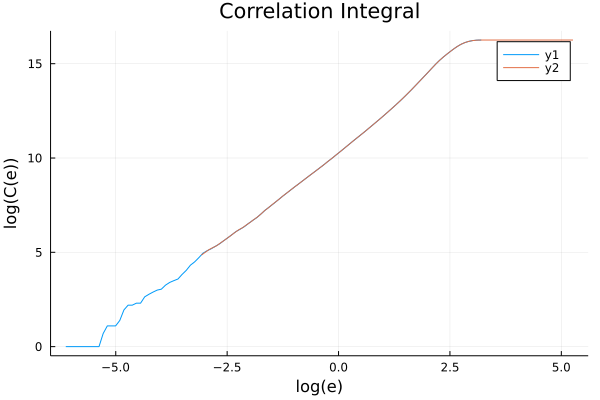

In [22]:
plot(log.(ϵ),log.(Cϵ),title="Correlation Integral",xlabel="log(e)",ylabel="log(C(e))")
plot!(log.(ϵ2),log.(Cϵ2))

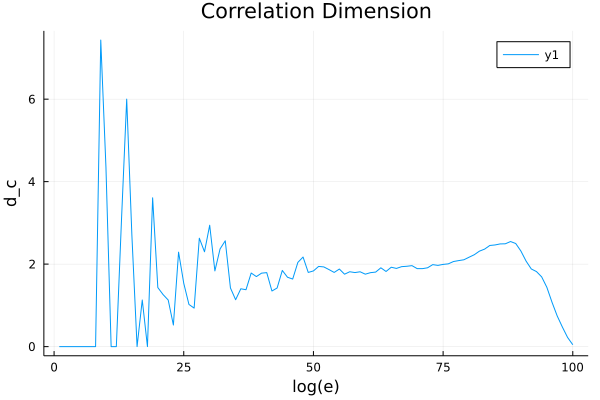

In [23]:
plot(diff(log.(Cϵ))./diff(log.(ϵ)),title="Correlation Dimension",xlabel="log(e)",ylabel="d_c")

Note that the "correct" answer is *about* 2 and this is the value we get over the largest *scaling region* between log(e)=40 and 70.

## Michael Small, 16/3/22, 19/4/21

More coming soon... we really want to automate this curve fitting process so we can just get a number (preferably, the "right" number) from the correlation integral. The standard way to do this is to identify through some *ad hoc* process a lower and upper bound on the scaling region and then fit a straight line in between. The other correlation dimension estimation algorithms (Gaussian Kernel Algorithm and Judd's) are all base on estimating other quantities from this curve (i.e. extra complication of extra correction factors). I'll try to get this implemented soon too...